### **SET B2 - Automatic Speech Recognition**

------

In [ ]:
!pip install transformers
!pip install -U datasets
!pip install soundfile
!pip install librosa
!pip install gradio

In [ ]:
#Suppresses warning messages

from transformers.utils import logging
logging.set_verbosity_error()

**Data Preparation**

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("librispeech_asr",
                       split="train.clean.100",
                       streaming=True,
                       trust_remote_code=True)

In [ ]:
example = next(iter(dataset))

In [ ]:
dataset_head = dataset.take(5)
list(dataset_head)

In [ ]:
list(dataset_head)[2]

In [ ]:
example

In [ ]:
#Text-To-Speech

from IPython.display import Audio as IPythonAudio

IPythonAudio(example["audio"]["array"],
             rate=example["audio"]["sampling_rate"])

**Building the pipeline**

In [ ]:
from transformers import pipeline

In [ ]:
asr = pipeline(task="automatic-speech-recognition",
               model="./models/distil-whisper/distil-small.en")

In [ ]:
asr.feature_extractor.sampling_rate

In [ ]:
example['audio']['sampling_rate']

In [ ]:
asr(example["audio"]["array"])

In [ ]:
example["text"]

**Building a Shareable app with Gradio**

In [ ]:
import os
import gradio as gr

In [ ]:
demo = gr.Blocks()

In [ ]:
def transcribe_speech(filepath):
    if filepath is None:
        gr.Warning("No audio found, please retry.")
        return ""
    output = asr(filepath)
    return output["text"]

Here we are allowing the users to set up the microphone

In [ ]:
mic_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="microphone",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never")

Here we are allowing them to be able to upload audio files

In [ ]:
file_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="upload",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never",
)

Add those two functionalities togther in gradio and start the demo

In [ ]:
with demo:
    gr.TabbedInterface(
        [mic_transcribe,
         file_transcribe],
        ["Transcribe Microphone",
         "Transcribe Audio File"],
    )

demo.launch(share=True, 
            server_port=int(os.environ['PORT1']))

In [ ]:
demo.close()

Output 1^

------

(Contd.) with the same setup, but will be adding some additional codes so that it can handle longer audio files

In [ ]:
import soundfile as sf
import io

audio, sampling_rate = sf.read('narration_example.wav')

In [ ]:
sampling_rate

In [ ]:
asr.feature_extractor.sampling_rate

In [ ]:
asr(audio)

*Note: Running the cell above will return:*

*ValueError: We expect a single channel audio input for AutomaticSpeechRecognitionPipeline*

Stereo channel/Stereo audio is the type which takes up different spaces to transmit audio (Spatial Audio) which enhances the listening experience.

But for the transformer model it must be in Mono i.e. in a single channel.


**Convert the audio from stereo to mono (Using librosa)**

In [ ]:
#If it is 2D, then it has two channels
audio.shape

In [ ]:
import numpy as np
audio_transposed = np.transpose(audio)

In [ ]:
audio_transposed.shape

In [ ]:
import librosa

In [ ]:
audio_mono = librosa.to_mono(audio_transposed)

In [ ]:
IPythonAudio(audio_mono,
             rate=sampling_rate)

In [ ]:
asr(audio_mono)

*Warning: The cell above might throw a warning because the sample rate of the audio sample is not the same of the sample rate of the model.*

In [ ]:
sampling_rate

In [ ]:
asr.feature_extractor.sampling_rate

In [ ]:
audio_16KHz = librosa.resample(audio_mono,
                               orig_sr=sampling_rate,
                               target_sr=16000)

Now, the whisper model (Selected by us) can only handle 30 seconds at once. Therefore we divide it into chunks and there will be a certain overlap of where the first chunk ends and the next one starts (So that when the final outputs are put together, there is a continuation). Note that the chunks are processed individually.

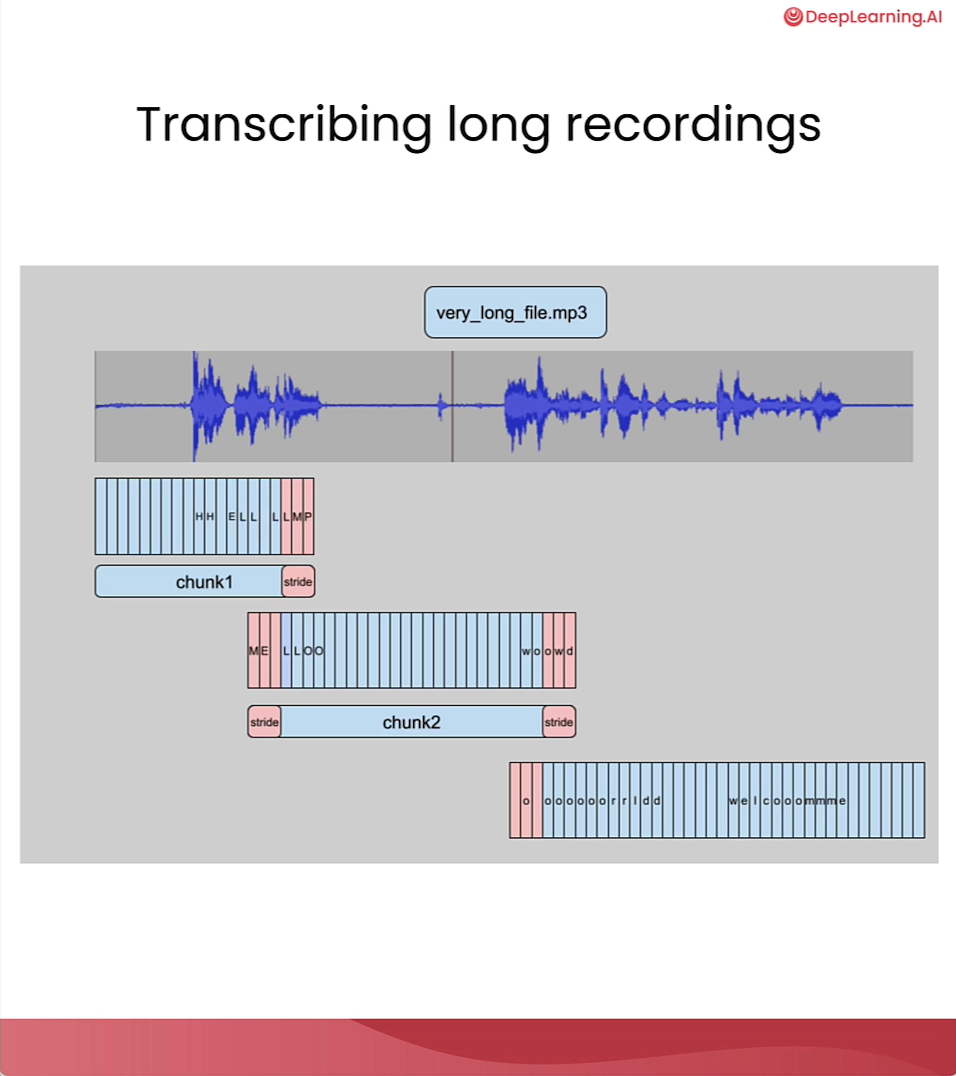

In [ ]:
asr(
    audio_16KHz,
    chunk_length_s=30, # 30 seconds
    batch_size=4,   #Adjust the batch size according to the memory your hardware can handle
    return_timestamps=True,
)["chunks"]

Building the Gradio interface

In [ ]:
import gradio as gr
demo = gr.Blocks()

In [ ]:
def transcribe_long_form(filepath):
    if filepath is None:
        gr.Warning("No audio found, please retry.")
        return ""
    output = asr(
      filepath,
      max_new_tokens=256,
      chunk_length_s=30,
      batch_size=8,
    )
    return output["text"]

In [ ]:
mic_transcribe = gr.Interface(
    fn=transcribe_long_form,
    inputs=gr.Audio(sources="microphone",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never")

file_transcribe = gr.Interface(
    fn=transcribe_long_form,
    inputs=gr.Audio(sources="upload",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never",
)

In [ ]:
with demo:
    gr.TabbedInterface(
        [mic_transcribe,
         file_transcribe],
        ["Transcribe Microphone",
         "Transcribe Audio File"],
    )
demo.launch(share=True, 
            server_port=int(os.environ['PORT1']))

In [ ]:
demo.close()

Output 2^

----------